# We will conver these topics-
1. UnderComplete Linear AutoEncoder
2. Stacked AutoEncoder
3. Convolutional AutoEncoder
4. Recurrent AutoEncoder
5. Denoising AutoEncoder
6. Sparse AutoEncoder
7. Variational AutoEncoder

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

def cls():
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

# 1. PCA using UnderComplete Linear AutoEncoder

In [3]:
cls()

encoder = tf.keras.models.Sequential([tf.keras.layers.Dense(2)]) # 2D
decoder = tf.keras.models.Sequential([tf.keras.layers.Dense(3)]) # 3D
autoencoder = tf.keras.models.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss='mse', optimizer=optimizer)

In [4]:
# Lets build some random 3D dataset
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit
X_train.shape

(60, 3)

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=100, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 0s/step


Text(0.5, 0.92, '3D plot of original data')

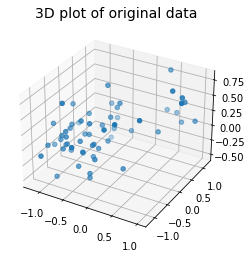

In [6]:
# This is 3D plot without interaction
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,1], X_train[:,0], X_train[:,2], 'gray')
ax.set_title("3D plot of original data")

<ipython-input-7-f437b98d56f8>:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


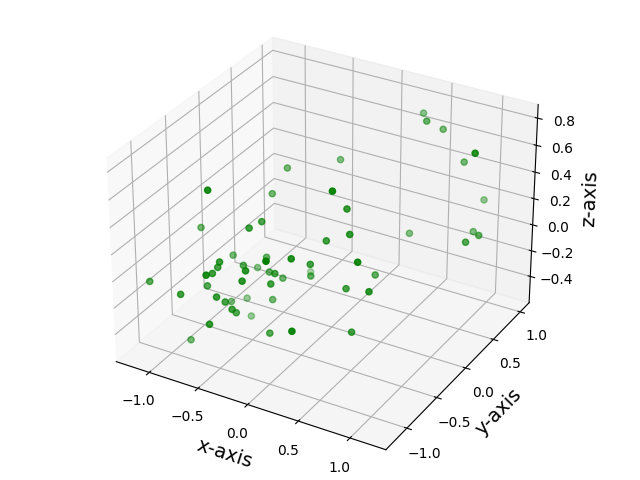

In [7]:
# 3D plot with interaction
import matplotlib
matplotlib.use("Agg")
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
  
# creating random dataset
xs = X_train[:,0]
ys = X_train[:,1]
zs = X_train[:,2]
fig = plt.figure()
ax = Axes3D(fig)
plot_geeks = ax.scatter(xs, ys, zs, color='green')
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.show()

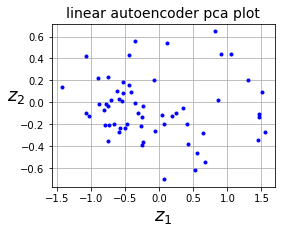

In [8]:
# This is 2D output that we got from decoder
%matplotlib inline
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.title('linear autoencoder pca plot')
plt.show()

# 2. Stacked AutoEncoders

In [9]:
#--------------------------
# lets load mnist dataset |
#--------------------------
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

In [10]:
# Our input is 2D so when we use Dense layer we need to make it flat
stacked_encoder = tf.keras.models.Sequential([
                    tf.keras.layers.Flatten(), # Flatten the neuron
                    tf.keras.layers.Dense(50, activation='relu'), # 1st HL
                    tf.keras.layers.Dense(10, activation='relu'), # coding 
])

#You can consider this as an regression task where we do not use activation at last layer
stacked_decoder = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(28*28), # Linear layer or output layer
                    tf.keras.layers.Reshape([28,28])
])

stacked_auto_encoder = tf.keras.models.Sequential([stacked_encoder,stacked_decoder])
stacked_auto_encoder.compile(loss='mse', optimizer='nadam')
history = stacked_auto_encoder.fit(X_train,X_train, epochs=10, 
                    validation_data=(X_valid, X_valid), verbose=False)


### 2.1. Visualizing the Reconstructions
The output of Decoder is called reconstruction

In [53]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 [==============================] - 0s 67ms/step


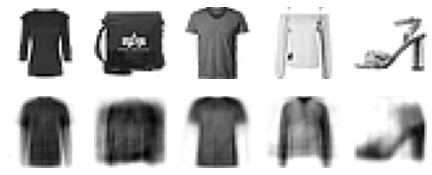

In [54]:
# You can see Images compressed down to 30 neuron and try
# to regain its original details of 784 neurons
plot_reconstructions(stacked_auto_encoder)
plt.show()

In [141]:
def plot_reconstructions_fake(model, shape, normal=False):
    input = tf.random.uniform(shape,0,1)
    if normal:
        input = tf.random.normal(shape)
    n_images = input.shape[0]
    reconstructions = np.clip(model(input), 0, 1)
    fig = plt.figure(figsize=(n_images * 2, 5))
    for image_index in range(n_images):
        plt.subplot(1, n_images, 1 + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")
    plt.show()

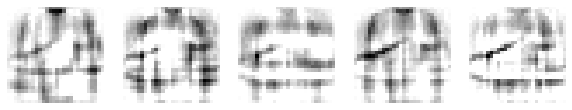

In [142]:
# Let generate some fake images
# Till now our decoder able to decode [Batch_size, 10] neuron to [Batch_size, 28, 28] image
# Lets feed it some random number to check how it will convert
plot_reconstructions_fake(stacked_decoder,(5,10))

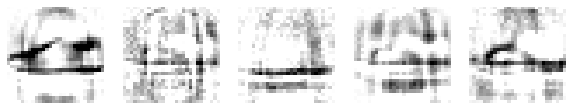

In [143]:
plot_reconstructions_fake(stacked_decoder,(5,10),normal=True)

In [87]:
# Not quite good It trying to merge shoes with shirts :o

### 2.2. Visualizing cluster of data
Lets visualize how image look like in 2D cluster

In [88]:
from sklearn.manifold import TSNE

x_valid_compressed = stacked_encoder.predict(X_valid) # Will give [Batch, 30] dim output
print("Dimension of X_valid compressed : ", x_valid_compressed.shape)
# Now we use another dimention reduction technique to
# visualize this data into 2D
tsne = TSNE(init="pca") # Default this reduce data in 2 dimension
x_valid_2D = tsne.fit_transform(np.asarray(x_valid_compressed, dtype='uint8'))

157/157 [==============================] - 0s 1ms/step
Dimension of X_valid compressed :  (5000, 10)


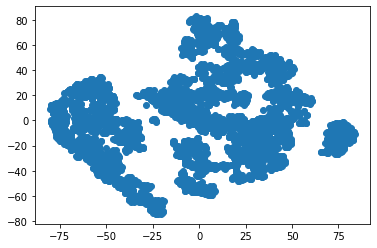

In [89]:
plt.scatter(x_valid_2D[:, 0], x_valid_2D[:, 1])
plt.show()

In [90]:
# There would be around 10 clusters
np.unique(y_valid)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

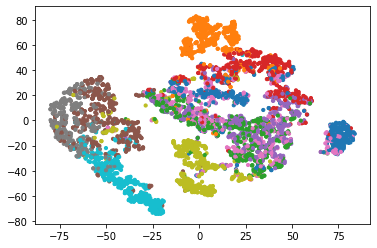

In [92]:
plt.scatter(x_valid_2D[:, 0], x_valid_2D[:, 1], 
            c=y_valid, s=10, cmap="tab10")
plt.show()

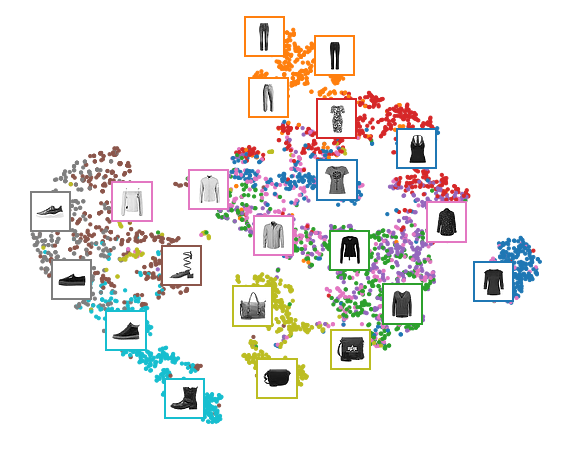

In [93]:
# Visualizing the Fashion MNIST

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = x_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), 
            "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

### 2.3. Tying Weights

It's a technique by which we can tie the weight of encoder layer
with the decoder. So it helps to reduce to quantity of total
parameters.

It is common to tie the weights of the encoder and the decoder, 
by simply using the transpose of the encoder's weights as the decoder weights. 
For this, we need to use a custom layer.

In [94]:
cls()

class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias',
                                    shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape) # must call at last

    def call(self, X):
        # Instead of multipling with new weights
        # we use previous layers weights
        Z = tf.matmul(X, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [95]:
cls()

# Lets creates layers seperately bcz we will use them to tie
# with decoder
dense_1 = tf.keras.layers.Dense(100,activation='relu')
dense_2 = tf.keras.layers.Dense(30, activation='relu')

tied_encoder = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(),
                dense_1,
                dense_2
])

tied_decoder = tf.keras.models.Sequential([
                DenseTranspose(dense_2, activation='relu'),
                DenseTranspose(dense_1),
                tf.keras.layers.Reshape([28,28])
])
tied_autoencoder = tf.keras.models.Sequential([tied_encoder,tied_decoder])
tied_autoencoder.compile(loss="mse", optimizer="nadam")
history = tied_autoencoder.fit(X_train, X_train, epochs=2,
                validation_data=(X_valid, X_valid), verbose=False)

In [96]:
dense_2.weights[1].shape

TensorShape([30])

In [97]:
for layers in tied_encoder.get_weights():
    print(layers.shape)

(784, 100)
(100,)
(100, 30)
(30,)


In [98]:
tied_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [99]:
tied_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_transpose (DenseTrans  (None, 100)              3130      
 pose)                                                           
                                                                 
 dense_transpose_1 (DenseTra  (None, 784)              79284     
 nspose)                                                         
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 82,414
Trainable params: 82,414
Non-trainable params: 0
_________________________________________________________________


In [100]:
for layers in tied_decoder.get_weights():
    print(layers.shape)

(100,)
(100, 30)
(30,)
(784,)
(784, 100)
(100,)


1/1 [==============================] - 0s 69ms/step


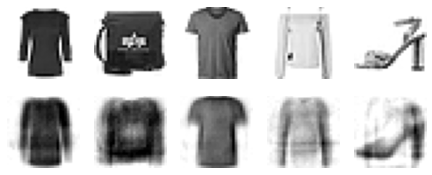

In [101]:
plot_reconstructions(tied_autoencoder)

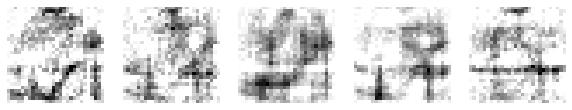

In [144]:
plot_reconstructions_fake(tied_decoder, (5,30))

### 2.3. Training one AutoEncoder at a Time

In [107]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=5,
                      output_activation=None, verbose=False):
    n_inputs = X_train.shape[-1] # number of dimension
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid), verbose=verbose)
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [108]:
cls()

# Putting Flat layer outside the function because when you combine both model
# then put flat layer inside while putting both model together
X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)

# Train Auto-Encoder with one HL have 50 neuron
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(50, X_train_flat, X_valid_flat)

In [ ]:
# Let train One Auto-Encoder more with one HL 30 neuron
enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, output_activation="relu")

In [130]:
print("First Encoder and Decoder weight shapes:")
print([_.shape for _ in enc1.get_weights()], [_.shape for _ in dec1.get_weights()]) 
print()
print("Second Encoder and Decoder weight shapes:")
print([_.shape for _ in enc2.get_weights()], [_.shape for _ in dec2.get_weights()])

First Encoder and Decoder weight shapes:
[(784, 50), (50,)] [(50, 784), (784,)]

Second Encoder and Decoder weight shapes:
[(50, 30), (30,)] [(30, 50), (50,)]


In [129]:
print("Trained Encoder shape : ", X_train_enc1.shape) # Encoder output [Batch_size, neurons]
print("Valid Encoder shape   : ", X_valid_enc1.shape) # Encoder output [Batch_size, neurons]

Trained Encoder shape :  (55000, 50)
Valid Encoder shape   :  (5000, 50)


In [135]:
# Putting all Together
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

# We can also train full auto-encoder for few epoch.
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
stacked_ae_1_by_1.fit(X_train, X_train, epochs=1,validation_data=(X_valid, X_valid))
stacked_ae_1_by_1.summary()

1719/1719 [==============================] - 4s 2ms/step - loss: 0.0160 - val_loss: 0.0156
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 50)                1550      
                                                                 
 dense_1 (Dense)             (None, 784)               39984     
                                                                 
 reshape_4 (Reshape)         (None, 28, 28)            0         
                             

In [138]:
[_.shape for _ in stacked_ae_1_by_1.get_weights()]

[(784, 50), (50,), (50, 30), (30,), (30, 50), (50,), (50, 784), (784,)]

1/1 [==============================] - 0s 97ms/step


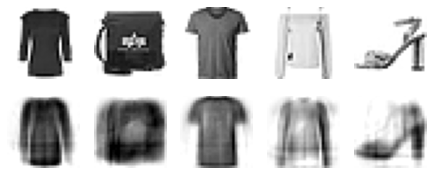

In [139]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

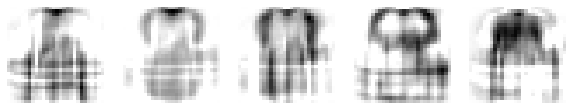

In [154]:
plot_reconstructions_fake(
                    tf.keras.models.Sequential([dec2, dec1, tf.keras.layers.Reshape([28, 28])]),  
                    (5, 30))

# Far better as compare to previous autoencoders

# 3. Convolutional Autoencoders
When you want to deal with 3D image you can use Convolutional Autoencoders

In [159]:
cls()

conv_encoder = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([28,28,1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(), # 14 x 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(), # 7 x 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(), # 3 x 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAveragePooling2D() # 30
])

# At first layer in decoder we got [batch,30 neuron]
# so we need to create Dense layer so that after
# reshape it into 3D it become image
conv_decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape([3,3,16]),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28, 1])

])

conv_autoencoder = tf.keras.models.Sequential([conv_encoder, conv_decoder])
conv_autoencoder.compile(loss="mse", optimizer="nadam")
history = conv_autoencoder.fit(X_train, X_train, epochs=5,
                        validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 49s 28ms/step - loss: 0.0336 - val_loss: 0.0232
Epoch 2/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.0210 - val_loss: 0.0194
Epoch 3/5
1719/1719 [==============================] - 46s 27ms/step - loss: 0.0180 - val_loss: 0.0176
Epoch 4/5
1719/1719 [==============================] - 48s 28ms/step - loss: 0.0163 - val_loss: 0.0154
Epoch 5/5
1719/1719 [==============================] - 49s 28ms/step - loss: 0.0150 - val_loss: 0.0146


In [160]:
conv_autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                40606     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         13873     
                                                                 
Total params: 54,479
Trainable params: 54,479
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 33ms/step


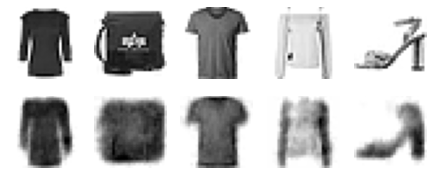

In [163]:
plot_reconstructions(conv_autoencoder)

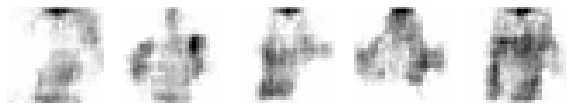

In [173]:
plot_reconstructions_fake(conv_decoder, (5, 30))

# 4. Recurrent AutoEncoders

In [174]:
# Lets dont create a sequencial dataset, Instead of 
# treat each [1,28,28] image as an 
# 1 instance, 28 timestep, with 28 dimension.

cls()

recurrent_encoder = tf.keras.models.Sequential([
    tf.keras.layers.GRU(30, return_sequences=True),
    tf.keras.layers.GRU(10)
])

# RepeatVector basically repeat the input to N dimension
# so the input of decoder = [None, 10] --> [None, 28, 10]
# As 28 is our timestep
recurrent_decoder = tf.keras.models.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.GRU(30, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(28))
])

recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer="nadam")

history = recurrent_ae.fit(X_train, X_train, epochs=2,
                           validation_data=(X_valid, X_valid))

Epoch 1/2
1719/1719 [==============================] - 65s 34ms/step - loss: 0.0418 - val_loss: 0.0291
Epoch 2/2
1719/1719 [==============================] - 61s 35ms/step - loss: 0.0269 - val_loss: 0.0253


1/1 [==============================] - 0s 19ms/step


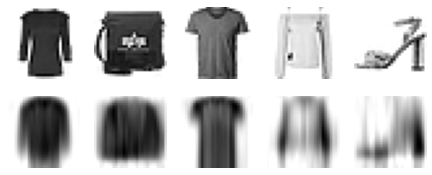

In [176]:
plot_reconstructions(recurrent_ae)

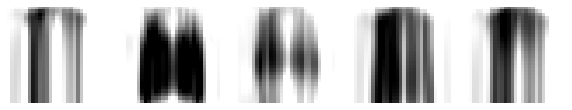

In [179]:
# Do you notice something
# Model try to repeat first row consecutively
# because we treat rows as an timestep
plot_reconstructions_fake(recurrent_decoder, (5, 10))

# 5. Denoising AutoEncoders
In order to force autoencoder to learn only interesting features
from coding. We have to constraint the coding neurons or remove
useless neurons from coding layer.
like regularization, dropout, adding random noise, so on.

In [180]:
# Lets use dropout layer

cls()

# Make note we are dropping Image neurons not
# Hidden layer's neurons

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(), # flattening bcz using Dense
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])

dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=2,
                         validation_data=(X_valid, X_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0304 - val_loss: 0.0226
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0231 - val_loss: 0.0208


1/1 [==============================] - 0s 23ms/step


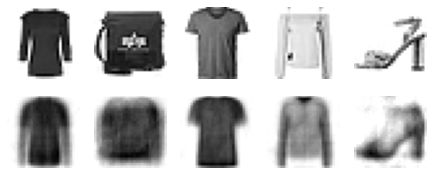

In [182]:
plot_reconstructions(dropout_ae)

1/1 [==============================] - 0s 32ms/step


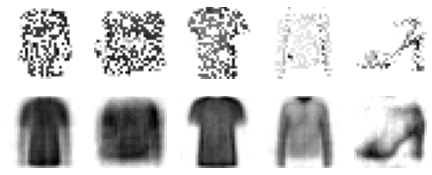

In [191]:
# When we pass training=True only then this layer compute output directly
plot_reconstructions(dropout_ae, tf.keras.layers.Dropout(0.5)(X_valid,training=True))

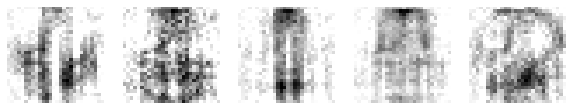

In [198]:
plot_reconstructions_fake(dropout_decoder, (5,30))

If you want, you can try replacing the `Dropout layer` with `tf.keras.layers.GaussianNoise(0.2)`

# 6. Sparse AutoEncoder

Let's use the sigmoid activation function in the coding layer. Let's also add regularization to it: to do this, we add an `ActivityRegularization` layer after the coding layer. Alternatively, we could add `activity_regularizer=tf.keras.regularizers.l1(1e-4)` to the coding layer itself.

### 6.1. Approach 1:
We can constraint the coding layer output. This will
encourage the model to give more information in short no.
of neurons.

In [199]:
cls()

# Using Sigmoid to coding layer contraint the output between 0 & 1.
# activations that close to 0 will die rest will give useful
# information

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(30, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=2,
                           validation_data=(X_valid, X_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0311 - val_loss: 0.0236
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0215 - val_loss: 0.0202


In [200]:
cls()
# Same can be done by - 
sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(30, activation="sigmoid",activity_regularizer=tf.keras.regularizers.l1(l1=1e-4)),
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=2,
                           validation_data=(X_valid, X_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0311 - val_loss: 0.0236
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0215 - val_loss: 0.0202


1/1 [==============================] - 0s 68ms/step


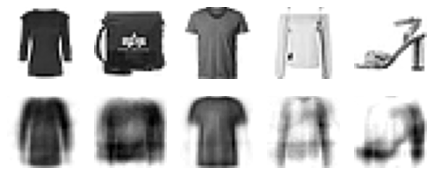

In [201]:
plot_reconstructions(sparse_l1_ae)

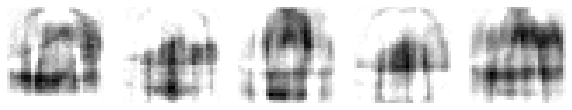

In [202]:
plot_reconstructions_fake(sparse_l1_decoder, (5, 30))

### 6.2. Using KL Divergence

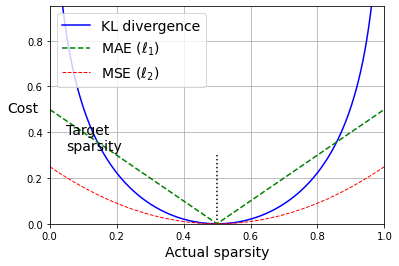

In [210]:
p = 0.5
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)

We want to measure the divergence between the target probability
p that a neuron in the coding layer will activate and the actual
probability q (i.e. the mean activation over the training batch)

In [217]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [218]:
# Use KL Divergence to push the model to have
# about 10% sparcity in the coding layer
# weight will use to define weightage contribution in loss

target = 0.1
kld_reg = KLDivergenceRegularizer(weight=5e-3, target=target)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(30, activation="sigmoid",
                            activity_regularizer=kld_reg)
])

sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=2,
                           validation_data=(X_valid, X_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0436 - val_loss: 0.0309
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0287 - val_loss: 0.0278


1/1 [==============================] - 0s 88ms/step


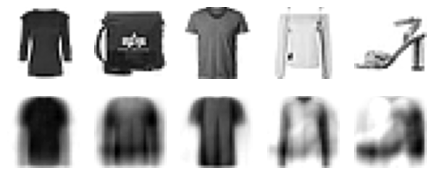

In [219]:
plot_reconstructions(sparse_kl_ae)

# 7. Variational AutoEncoder

In [221]:
# Variational AutoEncoder consist two losses
# 1 is latent_loss and second is generative_loss
# 
# Latent loss: This loss compares the latent vector with a zero mean,
# unit variance Gaussian distribution. The loss we use here will be 
# the KL divergence loss. This loss term penalizes the VAE if it 
# starts to produce latent vectors that are not from the desired 
# distribution.

# So ultimately decoder not receive actual latent vector or coding
# it recieve gaussian data

In [222]:
# Lets create a custom class that will generate Gaussian
# data for decoder
# exp(log_var/2) == std

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean


In [283]:
cls()
inputs = tf.keras.layers.Input([28,28])
z = tf.keras.layers.Flatten()(inputs)
z = tf.keras.layers.Dense(50, activation='relu')(z)
z = tf.keras.layers.Dense(20, activation='relu')(z)
coding_mean    = tf.keras.layers.Dense(10)(z)  # mean
coding_log_var = tf.keras.layers.Dense(10)(z)  # standard deviation
codings = Sampling()([coding_mean, coding_log_var])
variational_encoder = tf.keras.Model(inputs=[inputs],
                                outputs=[codings])

decoder_inputs = tf.keras.layers.Input(shape=[10])
x = tf.keras.layers.Dense(20, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(50, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], 
                        outputs=[outputs])

In [284]:
# Our data is not flowing sequentially so we use functional API

cls()
codings   = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], 
                outputs=[reconstructions])

# This is mean loss of an image [784 pixels]
latent_loss = -0.5 * tf.reduce_sum(
    1 + coding_log_var - tf.exp(coding_log_var) - tf.square(coding_mean),
    axis=-1)

variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=10, 
                        validation_data=(X_valid, X_valid),
                        verbose=False)

1/1 [==============================] - 0s 97ms/step


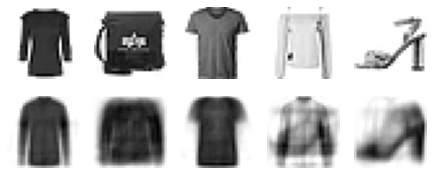

In [285]:
plot_reconstructions(variational_ae)
plt.show()

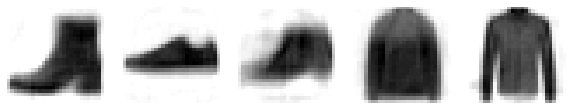

In [290]:
# Now lets pass normal distribution data
# as model is trained on that distribution
plot_reconstructions_fake(variational_decoder, (5,10), normal=True)

In [291]:
# As we can see these results are far better than
# we get earlier.